Tutorial 01: Profile translation with sea level rise using ShoreTrans (Type 4: Encroachment)

This notebook walks through a basic example of how to use the Fortran version of ShoreTrans
from Python, demonstrating its ability to model coastal profile translation under sea level rise.

We'll go step-by-step to:
1. Prepare input data and parameters
2. Run the ShoreTrans model
3. Visualize the resulting shoreline profile changes

The ShoreTrans model is designed to simulate long-term morphological evolution of coastal profiles
(10-100 years), taking into account processes like dune encroachment, armoring, sediment budget,
and more. This first example will build on a simple test case, slowly increasing the complexity.

Before we begin, make sure you have followed the steps in the readme file to compile shoretrans.

In [49]:
# Import necessary libraries
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


Each ShoreTrans simulation requires a folder with the following structure:

```
+---inputs
+---outputs
parameters.dat
```

- The inputs folder must contain the transect file to be analyzed.

- This file should be a plain text file with two columns: 
x and z (horizontal and vertical coordinates).

- The first line of the file must specify the number of points in the transect.

In [70]:
# Set the base directory and tutorial-specific folder
base_dir = Path.cwd()
input_dir = base_dir / "inputs"
output_dir = base_dir / "outputs"
input_dir.mkdir(exist_ok=True, parents=True)
output_dir.mkdir(exist_ok=True)

# copy the input files to the input directory
transect_source = base_dir.parent / "data" / "tutorial_data.txt"
transect_target = input_dir / "transect.txt"
shutil.copy(transect_source, transect_target)

# visualize the transect data
transect_df = pd.read_csv(transect_target, sep=",", skiprows=1)
transect_df.columns = ["x", "z"]
transect_df.head()

,x,z
0,1,0.821797
1,2,0.836738
2,3,0.852352
3,4,0.868945
4,5,0.885724


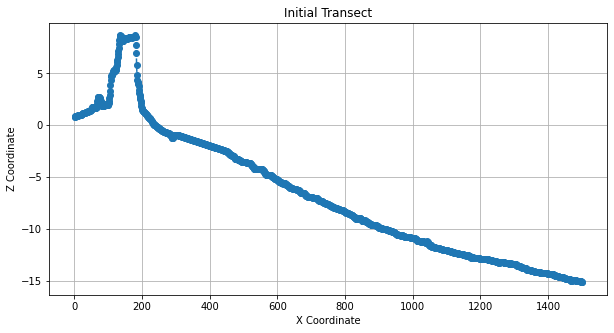

In [71]:
#plot the transect data
plt.figure(figsize=(10, 5))
plt.plot(transect_df["x"], transect_df["z"], marker="o", linestyle="--")
plt.title("Initial Transect")
plt.xlabel("X Coordinate")
plt.ylabel("Z Coordinate")
plt.grid()
plt.show()

We begin by visualizing the initial transect to be studied.
This gives us a reference for the shoreline profile before any simulation steps.

Next, we'll proceed to configure and run the actual simulation by setting up the required parameters.

But first, let's define a few helper functions to simplify the workflow.

In [83]:
# a function to write the parameters to a file
def write_parameters(params: dict, filepath: Path):
    with open(filepath, "w") as f:
        for key, val in params.items():
            f.write(f"{key} = {val}\n")

# a function to run the simulation
# this will run the shoretrans binary in the tutorial directory
# and will print the output in real-time
def run_shoretrans():
    if not shutil.which("shoretrans"):
        raise RuntimeError("'shoretrans' binary not found in PATH. Make sure it is compiled and accessible.")   
    
    process = subprocess.Popen(
        ["shoretrans", str(base_dir)],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
    )


    for line in process.stdout:
        print(line, end="\n")  # Real-time output

# a function to load the profile data
def load_profile(filepath):
    return np.loadtxt(filepath)

Next, we define our parameters, undefined parameters will be taken as a default value. 

As a minimum the code requires the xshorefilename and the doc.

- the grid resolution defaults to 1m, for a better accuracy, you may decrease the value of dx
- if not given, the toe_crest value will default to the max point in the profile, this may be useful for certain simulations (see the  next tutorial)
- the verbosity level ranges from 0 to 4 depending on the amount of detail you need to add in the output, by default it is 2 (only results are shown)

In [84]:

# define the parameters for the simulation
params1 = {
    "xshorefilename": "transect.txt",  # Input profile file
    "doc": -12,                         # Depth of closure (upper shoreface limit)
    "ds": 0.8,                          # Sea level rise (in meters)
    "toe_crest": 2.5,                   # Elevation of dune toe or crest
    "dx": 1.0,                          # Grid resolution (m)
    "verbose": 4                        # Optional logging verbosity
}
# write them to parameters.dat in the simulation folder
write_parameters(params1, "parameters.dat")


In [85]:
# and finally we run shoretrans
run_shoretrans()

b' end of parameter file /home/mtraboulsi/Desktop/tmp_lxshore/tutorials/01_basic/parameters.dat\n'
b' logging level set to      4\n'
b' Reading cross-shore profile from /home/mtraboulsi/Desktop/tmp_lxshore/tutorials/01_basic/inputs/transect.txt\n'
b' Number of points in profile: 1501\n'
b' setting toe/crest index: 196\n'
b' Depth of closure set to: -12.00000000\n'
b' Depth of closure index set to: 1090\n'
b' Depth of closure 2 not set, using doc2= -12.10000000\n'
b' Depth of closure 2 index set to: 1109\n'
b' slumping set to: 1 with slope: 30.00000000 and cap: 100.00000000\n'
b' xupp =                   410 xlow                 -195\n'
b' ds = 0.80000000\n'
b' h = 14.50000000\n'
b' w = 894.00000000\n'
b' Initial estimate (bruun) xi = -49.00000000 m (-49)\n'
b' xi_est                  -49\n'
b' xi =                   -49 error =   -242.60128723290836\n'
b' xi =                   -48 error =   -221.27806031156979\n'
b' xi =                   -50 error =   -263.73978904544492\n'
b'   21.2

## Interpreting ShoreTrans Output

Once ShoreTrans runs, it prints a detailed log of the entire process  including parameter loading, profile reading, depth indexing, and iterative solving for profile translation. This verbose output is helpful for transparency and debugging.

However, not all of this information is needed every time. You can reduce the output by setting `verbose = 2` in the parameters file (which is the default level).

The most relevant output appears at the end:

```
Final xi:  -37.000000000000000
Final dv (error): -1.52
```

This value represents the profile shift and volume error (in m³) between the target and the achieved shoreline profile after translation. In this example, an error of -1.52 m³ over a 1.4 km profile is negligible, which means the solution is already very close to the target.

Still, we can further improve the precision by using a finer grid resolution (`dx`). In the next step, we will rerun the model with a smaller `dx` value and compare the results.

In [86]:
# define the parameters for the simulation
params1 = {
    "xshorefilename": "transect.txt",  # Input profile file
    "doc": -12,                         # Depth of closure (upper shoreface limit)
    "ds": 0.8,                          # Sea level rise (in meters)
    "toe_crest": 2.5,                   # Elevation of dune toe or crest
    "dx": 0.01,                          # Grid resolution (m)
    "verbose": 2                        # Optional logging verbosity
}
# write them to parameters.dat in the simulation folder
write_parameters(params1, "parameters.dat")
run_shoretrans()

b' Depth of closure 2 not set, using doc2= -12.10000000\n'
b' xupp =                 41182 xlow               -19525\n'
b' xi_est                -4926\n'
b'  0.20230150141560443     \n'
b' xi_est                -3744\n'
b'  0.20112232263545593     \n'
b' xi_est                -3726\n'
b'  0.20064086726779351     \n'
b' Final xi:  -37.259999999999998       m (                -3726 )\n'
b' Final dv (error): -0.00657977\n'
b' saving final profile to: /home/mtraboulsi/Desktop/tmp_lxshore/tutorials/01_basic/z_final.out\n'
b' Program finished in      0.541 seconds.\n'
b' Program finished in      0.541 seconds.\n'


## High-resolution Output (dx = 0.01)

By setting `dx = 0.01`, we significantly increased the resolution of the shoreline profile. This results in:

- **More precise sediment budget calculations**
- **Smaller volume error** (`Final dv`)
- **Smoother shoreline translation**

In the output, we now see:

```
Final xi: -37.26 m
Final dv (error): -0.0066
Program finished in 0.588 seconds.
```

This means ShoreTrans estimated a shoreline retreat of about **37.26 meters**, and the volume mismatch is now **just 0.0066 m³**  virtually perfect.

The trade-off is **computational time**. While the original run (with `dx = 1.0`) took ~0.005 seconds, this high-resolution run took ~0.588 seconds. Still fast but something to consider when scaling up to many profiles or Monte Carlo runs.

This confirms that ShoreTrans supports fine-scale modeling and delivers highly accurate results when needed.

## Understanding ShoreTrans Output Files

After running ShoreTrans, two main output files are created in the `outputs/` folder:

- `initial_profile.out`:  
  This file contains the interpolated version of the input profile used in the computation.  
  It's especially useful when your input transect was coarse or irregular  ShoreTrans resamples it using the specified `dx`, ensuring a uniform grid.

- `z_final.out`:  
  This is the core result of the simulation  the **translated shoreline profile** after applying sea level rise and any other specified processes (e.g., sediment deficit, seawall, rock layer, etc).  
  It contains two columns: cross-shore distance and final elevation.

These files are saved in plain text and can be reloaded using any plotting tool or processed further in Python using `numpy.loadtxt()` or `pandas.read_csv()`.

Together, they allow you to compare **before and after** profiles with high precision.


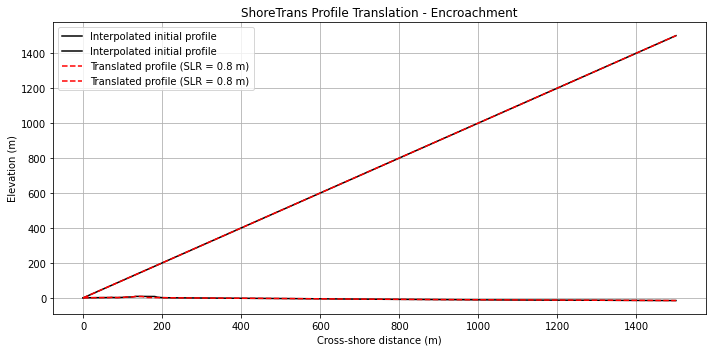

In [ ]:
initial_profile = load_profile(output_dir / "initial_profile.out")
final_profile = load_profile(output_dir / "z_final.out")

x = initial_profile[:, 0]
z_init = initial_profile[:, 1]
z_final = final_profile[:, 1]

plt.figure(figsize=(10,5))
plt.plot(x, z_init, 'k-', label="Interpolated initial profile")
plt.plot(x, z_final, 'r--', label="Translated profile (SLR = 0.8 m)")
plt.xlabel("Cross-shore distance (m)")
plt.ylabel("Elevation (m)")
plt.title("ShoreTrans Profile Translation - Encroachment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()